# Leitura de nota de corretagem

É necessário que o arquivo seja convertido em xml

In [1]:
pip install correpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import io

from correpy.parsers.brokerage_notes.b3_parser.b3_parser import B3Parser

import numpy as np
import pandas as pd
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Carregamento de dados

In [3]:
with open('/kaggle/input/btg-notas-de-corretagem-2022/BTG notas de corrertagem 2022.pdf', 'rb') as f:
    content = io.BytesIO(f.read())
    content.seek(0)
    
    brokerage_notes = B3Parser(brokerage_note=content).parse_brokerage_note()
    

In [4]:
notas_btg = pd.DataFrame(brokerage_notes)
notas_btg.head()

,reference_date,settlement_fee,registration_fee,term_fee,ana_fee,emoluments,operational_fee,execution,custody_fee,taxes,others,transactions
0,2022-05-20,0.15,0.38,0.00,0.00,0.20,0,0.00,0,0,0,"[{'transaction_type': TransactionType.BUY, 'am..."
1,2022-05-24,0.01,0.04,0.00,0.00,0.02,0,0.00,0,0,0,"[{'transaction_type': TransactionType.BUY, 'am..."
2,2022-05-25,0.00,0.02,0.00,0.00,0.01,0,0.00,0,0,0,"[{'transaction_type': TransactionType.BUY, 'am..."
3,2022-05-27,0.13,0.33,0.00,0.00,0.17,0,0.00,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."
4,2022-05-30,0.04,0.11,0.00,0.00,0.06,0,0.00,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."


In [5]:
with open('/kaggle/input/btg-notas-de-corretagem-2022/rama nota-de-corretagem-2022-combinado.pdf', 'rb') as f:
    content = io.BytesIO(f.read())
    content.seek(0)
    
    brokerage_notes = B3Parser(brokerage_note=content).parse_brokerage_note()

notas_orama = pd.DataFrame(brokerage_notes)
notas_orama.head()

,reference_date,settlement_fee,registration_fee,term_fee,ana_fee,emoluments,operational_fee,execution,custody_fee,taxes,others,transactions
0,2022-01-04,0,0,0,0,0,0,0,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."
1,2022-01-07,0,0,0,0,0,0,0,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."
2,2022-01-11,0,0,0,0,0,0,0,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."
3,2022-01-14,0,0,0,0,0,0,0,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."
4,2022-01-25,0,0,0,0,0,0,0,0,0,0,"[{'transaction_type': TransactionType.SELL, 'a..."


## Combinação dos arquivos

In [6]:
notas = pd.concat([notas_orama,notas_btg])
notas.shape

(108, 12)

## Normalização da coluna transactions

Note-se que a coluna `transactions` é composta por um dicionário.

Nos próximos passos, iremos abrir os dicionários e incorporar as colunas derivadas ao DataFrame `notas`.

In [7]:
transactions_exploded_df = notas[['transactions']].explode('transactions')
len(transactions_exploded_df)

213

In [8]:
print(len(transactions_exploded_df))
transactions_exploded_df.head()

213


,transactions
0,"{'transaction_type': TransactionType.SELL, 'am..."
0,"{'transaction_type': TransactionType.SELL, 'am..."
1,"{'transaction_type': TransactionType.SELL, 'am..."
1,"{'transaction_type': TransactionType.SELL, 'am..."
1,"{'transaction_type': TransactionType.SELL, 'am..."


In [9]:
print(type(transactions_exploded_df.iloc[0,0]))
transactions_exploded_df.iloc[0,0]

<class 'dict'>


{'transaction_type': <TransactionType.SELL: 'sell'>,
 'amount': 200,
 'unit_price': Decimal('3.80'),
 'security': {'name': 'OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA',
  'ticker': None},
 'source_withheld_taxes': Decimal('0.04')}

In [10]:
transactions_normalized_df = pd.json_normalize(transactions_exploded_df['transactions'])
transactions_normalized_df.index = transactions_exploded_df.index
transactions_normalized_df = transactions_normalized_df.rename(columns={'security.name': 'security_name', 'security.ticker': 'security_ticker'})
transactions_normalized_df.head(15)


,transaction_type,amount,unit_price,source_withheld_taxes,security_name,security_ticker
0,TransactionType.SELL,200,3.80,0.04,OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA,None
0,TransactionType.SELL,100,0.05,0.00,OPCAO DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,None
1,TransactionType.SELL,100,1.05,0.01,OPCAO DE VENDA 02/22 KLBNN256 UNT N2 KLABIN S/A,None
1,TransactionType.SELL,100,12.00,0.06,OPCAO DE VENDA 01/22 VALEM108 ON NM VALE,None
1,TransactionType.SELL,100,2.01,0.01,OPCAO DE VENDA 02/22 WEGEN309 ON NM WEG,EGEN3
1,TransactionType.SELL,100,1.01,0.01,OPCAO DE VENDA 02/22 BBDCN206 PN N1 BRADESCO,None
2,TransactionType.SELL,1000,0.05,0.00,OPCAO DE COMPRA 02/22 MGLUB899 ON NM MAGAZ LUIZA,None
3,TransactionType.SELL,100,0.17,0.00,OPCAO DE VENDA 01/22 GGBRM286 PN N1 GERDAU,None
3,TransactionType.SELL,100,1.15,0.01,OPCAO DE VENDA 02/22 VBBRN205 ON NM VIBRA,None
4,TransactionType.SELL,100,0.35,0.00,OPCAO DE COMPRA 03/22 SAPRC205 UNT N2 SANEPAR,None


In [11]:
notas = pd.merge(left = notas, right = transactions_normalized_df, how='right', left_index=True, right_index=True)
notas.reset_index(inplace=True, drop=True)
notas.pop('transactions')
notas.head()

,reference_date,settlement_fee,registration_fee,term_fee,ana_fee,emoluments,operational_fee,execution,custody_fee,taxes,others,transaction_type,amount,unit_price,source_withheld_taxes,security_name,security_ticker
0,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.SELL,200,3.80,0.04,OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA,None
1,2022-05-20,0.15,0.38,0.00,0.00,0.20,0,0.00,0,0,0,TransactionType.SELL,200,3.80,0.04,OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA,None
2,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.SELL,100,0.05,0.00,OPCAO DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,None
3,2022-05-20,0.15,0.38,0.00,0.00,0.20,0,0.00,0,0,0,TransactionType.SELL,100,0.05,0.00,OPCAO DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,None
4,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.BUY,200,0.78,0,DE VENDA 07/22 BBASS363 ON,BASS36


Agora vamos renomear as colunas conforme a nota de corregatem

In [12]:
notas = notas.rename(columns={'reference_date': 'data_op', 
                      'settlement_fee': 'tx_liq', 
                      'registration_fee': 'tx_regist', 
                      'term_fee': 'tx_termo', 
                      'ana_fee': 'tx_ana', 
                      'emoluments': 'emolumentos',
                     'operational_fee': 'tx_oper',
                     'execution':'execucao',
                     'custody_fee': 'tx_custodia',
                     'taxes': 'impostos',
                     'others': 'outros',
                     'transaction_type': 'tipo_transac',
                     'amount': 'quant',
                     'unit_price':'preco_unitario',
                     'source_withheld_taxes': 'irrf_fonte',
                     'security_name':'acao'})
notas.head()

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,outros,tipo_transac,quant,preco_unitario,irrf_fonte,acao,security_ticker
0,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.SELL,200,3.80,0.04,OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA,None
1,2022-05-20,0.15,0.38,0.00,0.00,0.20,0,0.00,0,0,0,TransactionType.SELL,200,3.80,0.04,OPCAO DE VENDA 04/22 BOVAP950 ISHARES BOVA,None
2,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.SELL,100,0.05,0.00,OPCAO DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,None
3,2022-05-20,0.15,0.38,0.00,0.00,0.20,0,0.00,0,0,0,TransactionType.SELL,100,0.05,0.00,OPCAO DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,None
4,2022-01-04,0,0,0,0,0,0,0,0,0,0,TransactionType.BUY,200,0.78,0,DE VENDA 07/22 BBASS363 ON,BASS36


In [13]:
notas['tipo_transac2'] = notas['tipo_transac'].apply(lambda x: 'compra' if ('TransactionType.BUY' == str(x)) else 'venda')
notas[['tipo_transac','tipo_transac2']].sample(n=10)

,tipo_transac,tipo_transac2
103,TransactionType.SELL,venda
147,TransactionType.BUY,compra
212,TransactionType.BUY,compra
171,TransactionType.SELL,venda
297,TransactionType.SELL,venda
102,TransactionType.SELL,venda
158,TransactionType.SELL,venda
92,TransactionType.SELL,venda
140,TransactionType.SELL,venda
27,TransactionType.SELL,venda


In [14]:
notas.pop('tipo_transac')

0      TransactionType.SELL
1      TransactionType.SELL
2      TransactionType.SELL
3      TransactionType.SELL
4       TransactionType.BUY
               ...         
320     TransactionType.BUY
321    TransactionType.SELL
322    TransactionType.SELL
323     TransactionType.BUY
324    TransactionType.SELL
Name: tipo_transac, Length: 325, dtype: object

In [15]:
notas.sample(n=20)

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,outros,quant,preco_unitario,irrf_fonte,acao,security_ticker,tipo_transac2
90,2022-02-24,0,0,0,0,0,0,0,0,0,0,100,0.50,0.00,OPCAO DE VENDA 04/22 SULAP260 UNT N2 SUL AMERICA,None,venda
213,2022-08-05,0.37,0.95,0.00,0.00,0.50,0,0.00,0,0,0,300,0.43,0,DE COMPRA 09/22 FLRYI165 ON,None,compra
112,2022-03-04,0,0,0,0,0,0,0,0,0,0,300,0.22,0.00,DE VENDA 08/22 PETRT241 ON,None,venda
101,2022-06-24,0.15,0.39,0.00,0.00,0.20,0,0.00,0,0,0,100,2.00,0.01,OPCAO DE VENDA 07/22 BOVAS970 ISHARES BOVA,None,venda
100,2022-02-25,0,0,0,0,0,0,0,0,0,0,100,2.00,0.01,OPCAO DE VENDA 07/22 BOVAS970 ISHARES BOVA,None,venda
141,2022-07-11,0.03,0.09,0.00,0.00,0.04,0,0.00,0,0,0,200,1.82,0.02,OPCAO DE VENDA 05/22 ENATQ220 ON NM ENAUTA PART,None,venda
159,2022-07-20,0.00,0.01,0.00,0.00,0.00,0,0.00,0,0,0,100,0.10,0.00,OPCAO DE COMPRA 04/22 KLBND250 UNT N2 KLABIN S/A,None,venda
183,2022-07-29,0.77,1.95,0.00,0.00,1.03,0,0.00,0,0,0,100,0.10,0.00,OPCAO DE COMPRA 06/22 SAPRF210 UNT N2 SANEPAR,None,venda
34,2022-01-25,0,0,0,0,0,0,0,0,0,0,100,1.72,0.01,DE VENDA 06/22 SULAR285 UNT,None,venda
110,2022-03-04,0,0,0,0,0,0,0,0,0,0,200,0.91,0.01,OPCAO DE VENDA 04/22 DXCOP140 ON NM DEXCO,None,venda


Os dados vindos da Orama vieram com o nome 'OPCAO' antes dos dados

In [16]:
notas['acao2'] = notas['acao'].apply(lambda x: x.replace('OPCAO',''))
notas.sample(n=20)

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,outros,quant,preco_unitario,irrf_fonte,acao,security_ticker,tipo_transac2,acao2
55,2022-06-13,0.48,1.21,0.00,0.00,0.64,0,0.00,0,0,0,100,1.33,0.01,OPCAO DE VENDA 10/22 PETRV30 PN N2 PETROBRAS,ETRV3,venda,DE VENDA 10/22 PETRV30 PN N2 PETROBRAS
151,2022-07-14,0.18,0.47,0.00,0.00,0.25,0,0.00,0,0,0,100,4.34,0,DE COMPRA 09/22 BOVAI940,None,compra,DE COMPRA 09/22 BOVAI940
27,2022-05-27,0.13,0.33,0.00,0.00,0.17,0,0.00,0,0,0,100,0.17,0.00,OPCAO DE VENDA 01/22 GGBRM286 PN N1 GERDAU,None,venda,DE VENDA 01/22 GGBRM286 PN N1 GERDAU
180,2022-04-28,0,0,0,0,0,0,0,0,0,0,200,3.98,0.04,DE COMPRA 08/22 BBASH334 ON,BASH33,venda,DE COMPRA 08/22 BBASH334 ON
286,2022-10-27,0.43,1.10,0.00,0.00,0.58,0,0.00,0,0,0,400,0.51,0,DE COMPRA 11/22 KLBNK215 UNT,None,compra,DE COMPRA 11/22 KLBNK215 UNT
246,2022-09-06,0.58,1.49,0.00,0.00,0.79,0,0.00,0,0,0,100,1.60,0,DE COMPRA 09/22 EMBRI115 ON,MBRI11,compra,DE COMPRA 09/22 EMBRI115 ON
101,2022-06-24,0.15,0.39,0.00,0.00,0.20,0,0.00,0,0,0,100,2.00,0.01,OPCAO DE VENDA 07/22 BOVAS970 ISHARES BOVA,None,venda,DE VENDA 07/22 BOVAS970 ISHARES BOVA
320,2022-12-14,0.91,2.31,0.00,0.00,1.23,0,0.00,0,0,0,100,1.32,0,DE COMPRA 02/23 PETRB32 PN,ETRB32,compra,DE COMPRA 02/23 PETRB32 PN
234,2022-08-25,0.01,0.02,0.00,0.00,0.01,0,0.00,0,0,0,300,0.13,0,DE VENDA 09/22 FLRYU150 ON,None,compra,DE VENDA 09/22 FLRYU150 ON
84,2022-02-21,0,0,0,0,0,0,0,0,0,0,100,1.50,0.01,OPCAO DE VENDA 04/22 SULAP260 UNT N2 SUL AMERICA,None,venda,DE VENDA 04/22 SULAP260 UNT N2 SUL AMERICA


In [17]:

notas['ticker'] = notas['acao2'].apply(lambda x: str(x.split()[3]))

notas['tipo_opcao'] = notas['acao2'].apply(lambda x: 'put' if str(x.split()[1]) == 'VENDA' else ('call' if str(x.split()[1]) == 'COMPRA' else 'None'))
notas['vencimento_opcao'] = notas['acao2'].apply(lambda x: str(x.split()[2]))
notas['total_operacao'] = notas['quant'] * notas['preco_unitario']
notas[['acao2','ticker','vencimento_opcao','tipo_opcao','quant','preco_unitario','total_operacao']]

,acao2,ticker,vencimento_opcao,tipo_opcao,quant,preco_unitario,total_operacao
0,DE VENDA 04/22 BOVAP950 ISHARES BOVA,BOVAP950,04/22,put,200,3.80,760.00
1,DE VENDA 04/22 BOVAP950 ISHARES BOVA,BOVAP950,04/22,put,200,3.80,760.00
2,DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,SAPRA20,01/22,call,100,0.05,5.00
3,DE COMPRA 01/22 SAPRA20 UNT N2 SANEPAR,SAPRA20,01/22,call,100,0.05,5.00
4,DE VENDA 07/22 BBASS363 ON,BBASS363,07/22,put,200,0.78,156.00
...,...,...,...,...,...,...,...
320,DE COMPRA 02/23 PETRB32 PN,PETRB32,02/23,call,100,1.32,132.00
321,DE VENDA 02/23 PETRN270 PN,PETRN270,02/23,put,200,2.59,518.00
322,DE VENDA 01/23 VIIAM350 ON,VIIAM350,01/23,put,400,1.50,600.00
323,DE VENDA 12/22 VIIAX350 ON,VIIAX350,12/22,put,400,1.55,620.00


## Exercício de opções

zerar saldo no exercício

In [69]:
notas[notas['ticker'] == '02/22']

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,...,acao,security_ticker,tipo_transac2,acao2,ticker,tipo_opcao,vencimento_opcao,total_operacao,saldo_operacao,saldo_quant
74,2022-02-18,0,0,0,0,0,0,0,0,0,...,EXERC OPV VENDA 02/22 KLBNN256E UNT N2 KLABIN S/A,None,venda,EXERC OPV VENDA 02/22 KLBNN256E UNT N2 KLABIN S/A,02/22,None,VENDA,2531.00,2531.00,-100
75,2022-06-17,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0,...,EXERC OPV VENDA 02/22 KLBNN256E UNT N2 KLABIN S/A,None,venda,EXERC OPV VENDA 02/22 KLBNN256E UNT N2 KLABIN S/A,02/22,None,VENDA,2531.00,2531.00,-100


In [70]:
notas[notas['ticker'] == '04/22']

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,...,acao,security_ticker,tipo_transac2,acao2,ticker,tipo_opcao,vencimento_opcao,total_operacao,saldo_operacao,saldo_quant
162,2022-04-14,0,0,0,0,0,0,0,0,0,...,EXERC OPV VENDA 04/22 EMBRP200E ON NM EMBRAER,None,venda,EXERC OPV VENDA 04/22 EMBRP200E ON NM EMBRAER,04/22,None,VENDA,2000.00,2000.00,-100
163,2022-07-26,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0,...,EXERC OPV VENDA 04/22 EMBRP200E ON NM EMBRAER,None,venda,EXERC OPV VENDA 04/22 EMBRP200E ON NM EMBRAER,04/22,None,VENDA,2000.00,2000.00,-100


In [41]:
notas['saldo_operacao'] = notas.tipo_transac2
notas['saldo_operacao'] = notas['saldo_operacao'].apply(lambda x: -1 if str(x) == 'compra' else 1)
notas['saldo_operacao'] = notas['saldo_operacao'] * notas['total_operacao']
notas['saldo_quant'] = notas.tipo_transac2
notas['saldo_quant'] = notas['saldo_quant'].apply(lambda x: 1 if str(x) == 'compra' else -1)
notas['saldo_quant'] = notas['saldo_quant'] * notas['quant']

notas[['tipo_transac2','quant','saldo_quant','preco_unitario','saldo_operacao']]


,tipo_transac2,quant,saldo_quant,preco_unitario,saldo_operacao
0,venda,200,-200,3.80,760.00
1,venda,200,-200,3.80,760.00
2,venda,100,-100,0.05,5.00
3,venda,100,-100,0.05,5.00
4,compra,200,200,0.78,-156.00
...,...,...,...,...,...
320,compra,100,100,1.32,-132.00
321,venda,200,-200,2.59,518.00
322,venda,400,-400,1.50,600.00
323,compra,400,400,1.55,-620.00


In [73]:
notas[['data_op','ticker','saldo_quant','saldo_operacao']].groupby(['ticker','data_op','saldo_quant']).agg('sum').head(10)


saldo_operacao
ticker   data_op    saldo_quant               
02/22    2022-02-18 -100               2531.00
         2022-06-17 -100               2531.00
04/22    2022-04-14 -100               2000.00
         2022-07-26 -100               2000.00
B3SAL145 2022-10-20  500               -465.00
         2022-12-07  400                -12.00
         2022-12-15 -100                  1.00
B3SAL155 2022-10-20 -500                275.00
         2022-11-09  500               -360.00
B3SAV128 2022-09-06 -300                300.00

In [77]:
notas[notas['ticker'] == 'B3SAL145']

,data_op,tx_liq,tx_regist,tx_termo,tx_ana,emolumentos,tx_oper,execucao,tx_custodia,impostos,...,acao,security_ticker,tipo_transac2,acao2,ticker,tipo_opcao,vencimento_opcao,total_operacao,saldo_operacao,saldo_quant
280,2022-10-20,0.25,0.65,0.00,0.00,0.34,0,0.00,0,0,...,DE COMPRA 12/22 B3SAL145 ON,None,compra,DE COMPRA 12/22 B3SAL145 ON,B3SAL145,call,12/22,465.00,-465.00,500
314,2022-12-07,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0,...,DE COMPRA 12/22 B3SAL145 ON,None,compra,DE COMPRA 12/22 B3SAL145 ON,B3SAL145,call,12/22,12.00,-12.00,400
324,2022-12-15,0.00,0.00,0.00,0.00,0.00,0,0.00,0,0,...,DE COMPRA 12/22 B3SAL145 ON,None,venda,DE COMPRA 12/22 B3SAL145 ON,B3SAL145,call,12/22,1.00,1.00,-100


In [40]:
notas['competencia'] = notas['data_op'].resample('M', kind = 'period').last()
notas[['data_op','competencia']]             

TypeError: axis must be a PeriodIndex, but got an instance of RangeIndex

<AxesSubplot: xlabel='data_op', ylabel='saldo_operacao'>

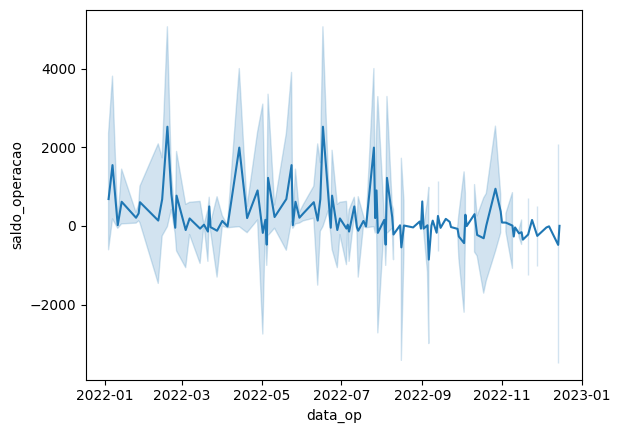

In [32]:
sns.lineplot(data = notas,
           x = 'data_op',
           y = 'saldo_operacao',
            estimator = 'sum');